In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib as plt
from scipy import stats
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV

<h2 id="Data_Import">1. Data Import</h2>

In [2]:
data = pd.read_csv('drugs.csv')

<h2 id="Data_Understanding">2. Data Understanding and Manipulation</h2>

<h4><i>Show data header</i></h4>

In [3]:
data.head(3)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC


<h4><i>Show names of columns</i></h4>

In [4]:
print(data.columns)

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype='object')


<h4><i>Data information</i></h4>

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
Age            200 non-null int64
Sex            200 non-null object
BP             200 non-null object
Cholesterol    200 non-null object
Na_to_K        200 non-null float64
Drug           200 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


We don't need to fix the data types since all the columns are the appropriate format. Also, the column names are short and comprehensible.



<h2 id="Data_Processing">3. Data Processing</h2>

<h3> Dealing with missing data</h3>

In [6]:
#Count missing values in each column
print(str('Is there any NaN value in the dataset: '), data.isnull().values.any())

Is there any NaN value in the dataset:  False


No missing values.

<h3> Drop the duplicate rows</h3>

In [7]:
# detect rows containing duplicate data
duplicate_rows = data[data.duplicated()]
print('number of duplicate rows: (dup rows, columns)', duplicate_rows.shape)

number of duplicate rows: (dup rows, columns) (0, 6)


No duplicate rows.

<h2 id="Data_Processing">4. Data Exploration</h2>

<h3><i>Data Description</i></h3>

<h4><i>Numerical variables:</i></h4>


In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,200.0,44.315000,16.544315,15.000,31.0000,45.0000,58.00,74.000
Na_to_K,200.0,16.084485,7.223956,6.269,10.4455,13.9365,19.38,38.247


<h4><i>Categorical variables:</i></h4>

In [9]:
data.describe(include=['object']).T

,count,unique,top,freq
Sex,200,2,M,104
BP,200,3,HIGH,77
Cholesterol,200,2,HIGH,103
Drug,200,5,drugY,91



<h3><i>Target Variable (Drugs)</i></h3>

Different Drugs and Their Counts:

In [10]:
df = data['Drug'].value_counts()
df = pd.DataFrame(df)
df.T

,drugY,drugX,drugA,drugB,drugC
Drug,91,54,23,16,16


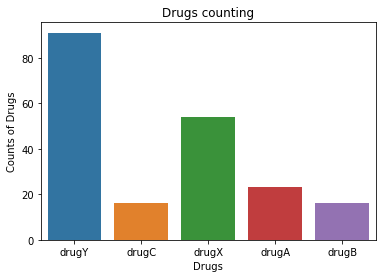

In [11]:
import matplotlib.pyplot as plt 
sns.countplot(data['Drug'])
plt.xlabel('Drugs')
plt.ylabel('Counts of Drugs')
plt.title('Drugs counting')
plt.show()

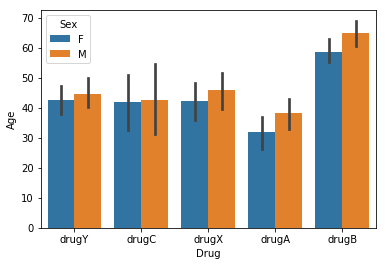

In [12]:
data.groupby(['Drug','Sex'])['Age'].mean()
sns.barplot(x="Drug", y="Age", hue="Sex", data=data)


<p><b>Insights:</b></p>
<ul>
    <li>The most often given drug to patients is the "drug Y"</li>
    <li>Drugs: Y, C, X and A are given to people under 50 years old </li>
    <li>Drug B is given to people from different ages including aged ones +50 years </li>
    <li>Men consume more of all types of  drugs  </li>
    
</ul>


<h3><i>Features</i></h3>

<h4>Sex, BP and Age:</h4>

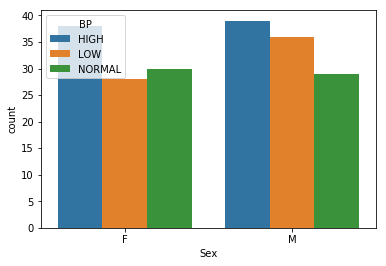

In [13]:
sns.countplot(data['Sex'],hue=data['BP'])

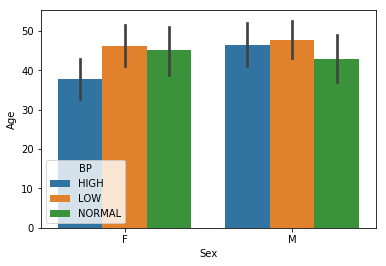

In [14]:
sns.barplot(x="Sex", y="Age", hue="BP",data=data)

<h4>Sex, Cholesterol and Age:</h4>

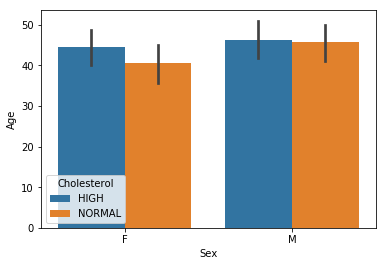

In [15]:

sns.barplot(x="Sex", y="Age", hue="Cholesterol",data=data)

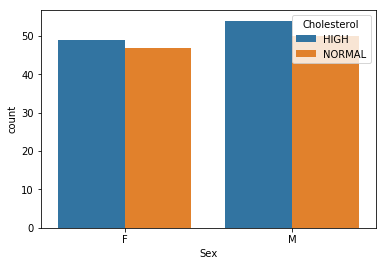

In [16]:
sns.countplot(data['Sex'],hue=data['Cholesterol'])

<h4>Sex , BP, Cholesterol and Age:</h4>

In [17]:
data['combined: BP_Cholesterol'] = data.apply(lambda x:'%s_%s' % (x['BP'],x['Cholesterol']),axis=1)
print(data['combined: BP_Cholesterol'].unique())

['HIGH_HIGH' 'LOW_HIGH' 'NORMAL_HIGH' 'LOW_NORMAL' 'HIGH_NORMAL'
 'NORMAL_NORMAL']


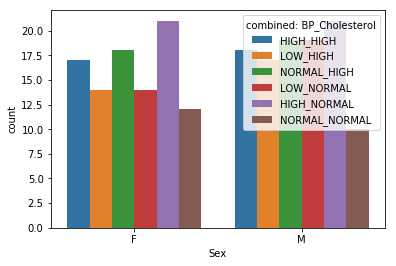

In [18]:
sns.countplot(data['Sex'],hue=data['combined: BP_Cholesterol'])

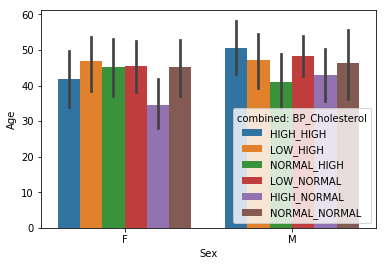

In [19]:
sns.barplot(x="Sex", y="Age", hue=data['combined: BP_Cholesterol'],data=data)

<h3><i>Analyzing and Dealing with Outliers</i></h3>

<h4><i>Numerical variables</i></h4>

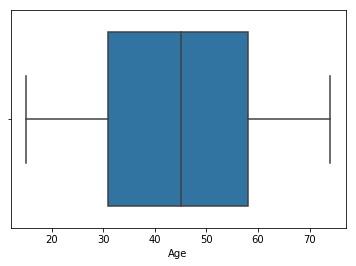

In [20]:
sns.boxplot(x=data['Age'])

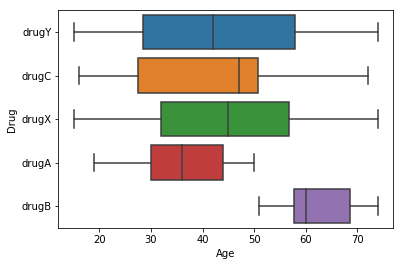

In [21]:
sns.boxplot(x="Age", y="Drug", data=data)

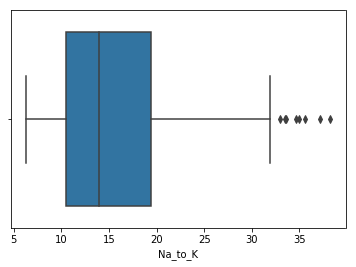

In [22]:
sns.boxplot(x=data['Na_to_K'])

There's no outliers in "Age" while, in 'Na_to_K we note the presence of many outliers'.

In [23]:
dfw = data['Na_to_K']
dfw_Q1 = dfw.quantile(0.25)
dfw_Q3 = dfw.quantile(0.75)
dfw_IQR = dfw_Q3 - dfw_Q1
dfw_lowerend = dfw_Q1 - (1.5 * dfw_IQR)
dfw_upperend = dfw_Q3 + (1.5 * dfw_IQR)

In [24]:
dfw_outliers = dfw[(dfw < dfw_lowerend) | (dfw > dfw_upperend)]
print("the list of the outliers:")
dfw_outliers.to_frame()

the list of the outliers:


,Na_to_K
24,33.486
96,38.247
98,35.639
128,33.542
131,32.922
184,37.188
188,34.997
194,34.686


In [25]:
outliers=data.iloc[[24,96,98,128,131,184,188,194]]
outliers

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,combined: BP_Cholesterol
24,33,F,LOW,HIGH,33.486,drugY,LOW_HIGH
96,58,F,LOW,HIGH,38.247,drugY,LOW_HIGH
98,20,M,HIGH,NORMAL,35.639,drugY,HIGH_NORMAL
128,47,M,LOW,NORMAL,33.542,drugY,LOW_NORMAL
131,52,M,LOW,NORMAL,32.922,drugY,LOW_NORMAL
184,18,F,HIGH,HIGH,37.188,drugY,HIGH_HIGH
188,65,M,HIGH,NORMAL,34.997,drugY,HIGH_NORMAL
194,46,F,HIGH,HIGH,34.686,drugY,HIGH_HIGH


In [26]:
data = data.drop([24,96,98,128,131,184,188,194])

<h2 id="Model Development">5. Model Development</h2>

<h3><i>Data Preparation</i></h3>

In this subsection we will:

1. Separate Dependant and Independant Variables
2. Transform categorical columns into numerical values
3. Split data set into training and testing parts (80/20)
4. Scale both training and testing input data

In [27]:
# Separate Dependant and Independant Variables
X = data[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']]
Y = data['Drug']

In [28]:
# Transform categorical columns into numerical values
X = pd.concat([X,pd.get_dummies(data['Sex'], prefix='Sex')], axis=1).drop(['Sex'],axis=1)
X = pd.concat([X,pd.get_dummies(data['BP'], prefix='BP')], axis=1).drop(['BP'],axis=1)
X = pd.concat([X,pd.get_dummies(data['Cholesterol'], prefix='Cholesterol')], axis=1).drop(['Cholesterol'],axis=1)
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192 entries, 0 to 199
Data columns (total 9 columns):
Age                   192 non-null int64
Na_to_K               192 non-null float64
Sex_F                 192 non-null uint8
Sex_M                 192 non-null uint8
BP_HIGH               192 non-null uint8
BP_LOW                192 non-null uint8
BP_NORMAL             192 non-null uint8
Cholesterol_HIGH      192 non-null uint8
Cholesterol_NORMAL    192 non-null uint8
dtypes: float64(1), int64(1), uint8(7)
memory usage: 5.8 KB
None


In [29]:
X.head(3)

,Age,Na_to_K,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,23,25.355,1,0,1,0,0,1,0
1,47,13.093,0,1,0,1,0,1,0
2,47,10.114,0,1,0,1,0,1,0


In [30]:
# Split data set into training and testing parts (80/20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [31]:
# Scale both training and testing input data

X_train = preprocessing.scale(X_train)

X_test = preprocessing.scale(X_test)
print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)

Train set: (153, 9) (153,)
Test set: (39, 9) (39,)


C:\Users\rahmaa\Anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\rahmaa\Anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  """


<h3><i>Model1: KNN</i></h3>

<h4><i>KNN Training</i></h4>

In [32]:
from sklearn.neighbors import KNeighborsClassifier
k = 4
#Train Model  
drugKNN = KNeighborsClassifier(n_neighbors = k).fit(X_train,Y_train)
#Shows the default parameters
drugKNN

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

<h4><i>KNN Prediction and Evaluation</i></h4>

In [33]:
#Predict test data set
KNN_pred = drugKNN.predict(X_test)
#Checking performance our model with classification report.
print(classification_report(Y_test, KNN_pred))
#Checking performance our model with Accuracy.
print("KNN's Accuracy: ", metrics.accuracy_score(Y_test, KNN_pred))

              precision    recall  f1-score   support

       drugA       0.80      1.00      0.89         4
       drugB       0.40      1.00      0.57         2
       drugC       0.75      1.00      0.86         3
       drugX       0.93      1.00      0.96        13
       drugY       1.00      0.65      0.79        17

   micro avg       0.85      0.85      0.85        39
   macro avg       0.78      0.93      0.81        39
weighted avg       0.91      0.85      0.85        39

KNN's Accuracy:  0.8461538461538461


<h3><i>Model2: Decision Tree</i></h3>

<h4><i>Decision Tree Training</i></h4>

In [34]:
from sklearn.tree import DecisionTreeClassifier
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_train,Y_train)
drugTree


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

<h4><i>Decision Tree Prediction and Evaluation</i></h4>

In [35]:
#Predict test data set
DT_pred = drugTree.predict(X_test)
#Checking performance our model with classification report.
print(classification_report(Y_test, DT_pred))
#Checking performance our model with Accuracy.
print("DT's Accuracy: ", metrics.accuracy_score(Y_test, DT_pred))

              precision    recall  f1-score   support

       drugA       0.80      1.00      0.89         4
       drugB       1.00      1.00      1.00         2
       drugC       0.75      1.00      0.86         3
       drugX       1.00      1.00      1.00        13
       drugY       1.00      0.88      0.94        17

   micro avg       0.95      0.95      0.95        39
   macro avg       0.91      0.98      0.94        39
weighted avg       0.96      0.95      0.95        39

DT's Accuracy:  0.9487179487179487


<h3><i>Model3: Random Forest</i></h3>

<h4><i>Random Forest Training</i></h4>

In [36]:
from sklearn.ensemble import RandomForestClassifier
drugForest = RandomForestClassifier(random_state=0).fit(X_train,Y_train)
drugForest


C:\Users\rahmaa\Anaconda3\envs\DeepLearning\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

<h4><i>Random Forest Prediction and Evaluation</i></h4>

In [37]:
#Predict test data set
RF_pred = drugForest.predict(X_test)
#Checking performance our model with classification report.
print(classification_report(Y_test, RF_pred))
#Checking performance our model with Accuracy.
print("RF's Accuracy: ", metrics.accuracy_score(Y_test, RF_pred))

              precision    recall  f1-score   support

       drugA       1.00      1.00      1.00         4
       drugB       1.00      1.00      1.00         2
       drugC       0.75      1.00      0.86         3
       drugX       1.00      1.00      1.00        13
       drugY       1.00      0.94      0.97        17

   micro avg       0.97      0.97      0.97        39
   macro avg       0.95      0.99      0.97        39
weighted avg       0.98      0.97      0.98        39

RF's Accuracy:  0.9743589743589743


<h2 id="Model Optimization">6. Model Optimization</h2>

<h3><i>Model1: KNN</i></h3>

<p>We will use grid search in order to obtain good parameters for our model. Of course our optimization here will be limited due to time and computing power constraints. The parameters we will optimize are:></p>
<ul>
    <li>leaf_size</li>
    <li>n_neighbors (K) </li>
    <li>p</li>
    
</ul>

In [38]:
#List of Hyperparameters that we want to tune
leaf_size = list(range(1,10))
n_neighbors = list(range(1,10))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_1 = KNeighborsClassifier()
#Use GridSearch
grid1 = GridSearchCV(knn_1, hyperparameters, cv=5)
#Fit the model
grid1.fit(X_train,Y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', grid1.best_estimator_.get_params()['leaf_size'])
print('Best p:', grid1.best_estimator_.get_params()['p'])
print('Best n_neighbors:', grid1.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 2
Best n_neighbors: 1


C:\Users\rahmaa\Anaconda3\envs\DeepLearning\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


From GridSearch, it can be seen that the best number of leaf_size is 1 while the optimal distance method is Manhattan or p = 1.
Then the most optimal number of K is 1.

<h3><i>Model2: Decision Tree</i></h3>

<p>The parameters we will optimize are:</p>
<ul>
    <li>criterion</li>
    <li>max_depth </li>
</ul>

In [39]:
rf_param_grid = { 'max_depth':[4,6,8,12] ,'criterion':['gini', 'entropy']}
            
                
#Fit the GridSearch model
grid2= GridSearchCV(estimator= DecisionTreeClassifier(), param_grid = rf_param_grid,  n_jobs=-1, verbose=0)
grid2.fit(X_train,Y_train)


C:\Users\rahmaa\Anaconda3\envs\DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\rahmaa\Anaconda3\envs\DeepLearning\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [4, 6, 8, 12], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [40]:
grid2.best_params_

{'criterion': 'gini', 'max_depth': 4}

In [41]:
grid2.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

<h3><i>Model3: Random Forest</i></h3>

<p>The parameters we will optimize are:</p>
<ul>
    <li>n-estimators</li>
    <li>min_samples_leaf </li>
    <li>max_features </li>
    <li>bootstrap</li>
    
</ul>

In [42]:
#List of Hyperparameters that we want to tune
rf_param_grid = {'max_features': ['sqrt', 'auto'],
              'min_samples_leaf': [1, 3, 5],
              'n_estimators': [100, 500, 1000],
             'bootstrap': [False, True]}
#Fit the GridSearch model
grid3= GridSearchCV(estimator= RandomForestClassifier(), param_grid = rf_param_grid,  n_jobs=-1, verbose=0)
grid3.fit(X_train,Y_train)


C:\Users\rahmaa\Anaconda3\envs\DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\rahmaa\Anaconda3\envs\DeepLearning\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': ['sqrt', 'auto'], 'min_samples_leaf': [1, 3, 5], 'n_estimators': [100, 500, 1000], 'bootstrap': [False, True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [43]:
grid3.best_params_

{'bootstrap': True,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [44]:
grid3.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Separating Dependant and Independant Variables
Dividing Dataset into Train and Test Datasets



This kernel consists of three objectives:

1)Perform exploratory analysis to extract meaningful insight from the data and identify the best features to be used for modeling.

2)Train, test, and refine various classification models to best predict which passengers survived. The predictive algorithms to be trained are:

Logistic Regression
Linear Support Vector Classifier (SVC)
Kernel Support Vector Classifier (Kernel SVC)
K-Nearest Neighbors (KNN)
Decision Tree
Random Forest
3)Apply the best performing model to the test set for contest submission.

<h2 id="Model Evaluation">7. Model Evaluation</h2>


<h3><i>Model1: KNN</i></h3>

In [45]:
# prediction
grid1_predictions = grid1.predict(X_test)
# evaluation
print("KNN's Accuracy: ", metrics.accuracy_score(Y_test, grid1_predictions))
print("KNN's jaccard_similarity_score: ", jaccard_similarity_score(Y_test, grid1_predictions))

KNN's Accuracy:  0.8974358974358975
KNN's jaccard_similarity_score:  0.8974358974358975


<h3><i>Model2: Decision Tree</i></h3>

In [46]:
# prediction
grid2_predictions = grid2.predict(X_test)
# evaluation
print("DT's Accuracy: ", metrics.accuracy_score(Y_test, grid2_predictions))
print("DT's jaccard_similarity_score: ", jaccard_similarity_score(Y_test, grid2_predictions))

DT's Accuracy:  0.9487179487179487
DT's jaccard_similarity_score:  0.9487179487179487


<h4><i>Decision Tree Visualization</i></h4>


In [47]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

<h3><i>Model3: Random Forest</i></h3>

In [48]:
# prediction
grid3_predictions = grid3.predict(X_test)
print("RF's Accuracy: ", metrics.accuracy_score(Y_test, grid3_predictions))
print("RF's jaccard_similarity_score: ", jaccard_similarity_score(Y_test, grid3_predictions))

RF's Accuracy:  0.9743589743589743
RF's jaccard_similarity_score:  0.9743589743589743


<h2 id="Feature Importance">8. Feature Importance</h2>

<h3><i>Model1: Decision Tree</i></h3>

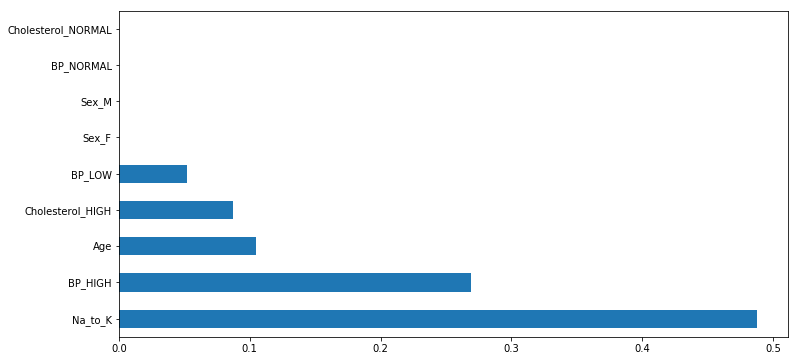

In [49]:

(pd.Series(drugTree.feature_importances_, index=X.columns)
   .nlargest(9)
   .plot(kind='barh',figsize=(12, 6)))  

<h3><i>Model3: Random Forest</i></h3>

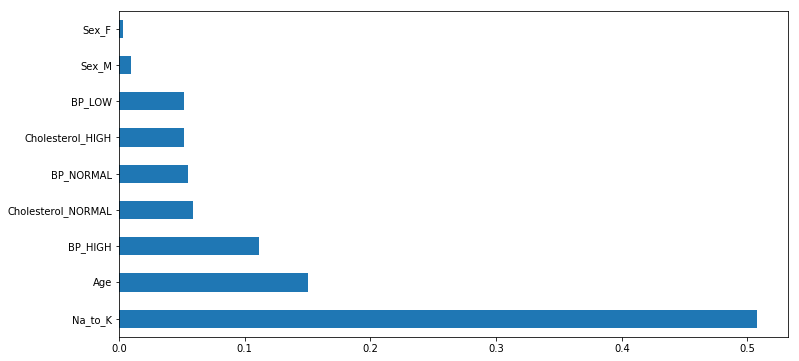

In [50]:
(pd.Series(drugForest.feature_importances_, index=X.columns)
   .nlargest(9)
   .plot(kind='barh',figsize=(12, 6)))  